In [1]:
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import datetime
from config import *
import sklearn 
from sklearn.model_selection import StratifiedKFold

sns.set(rc={'figure.figsize':(16,6)})

In [2]:
### movement raw
#

dMove = pd.read_csv(DATA_PATH + '/asset_movement.csv', delimiter=';')
for type in ['from_lat', 'from_lon', 'to_lat', 'to_lon']:
    dMove[type] = [float(v.replace(',', '.')) for v in dMove[type]]
for t in ['departure_time', 'arrival_time']:
    dMove[t] = pd.to_datetime([x.split(' ')[0] for x in dMove[t]])
# dMove['arrival_time'] = pd.to_datetime(dMove['arrival_time'])
# dMove['departure_time'] = pd.to_datetime(dMove['departure_time'])
    
dMove['dist'] = ((dMove['from_lat'] - dMove['to_lat'])**2 + (dMove['from_lon'] - dMove['to_lon'])**2) ** .5
dMove = dMove[['asset_id', 'departure_time', 'arrival_time', 'dist']]

### depart-arrival to multi-records
###   - To unify data format, we convert dMove to dMove2 which expand depart-to-arrival to multiple single-day records
###   - Expand depart-arrival & asset-id to multiple days, divide distance by days
ids, times, dists = [], [], []
for idx, r in dMove.iterrows():
    days = (r['arrival_time'] - r['departure_time']).days + 1
    
    ids += [r['asset_id']] * days
    times += [ r['departure_time'] + datetime.timedelta(days=i) for i in range(days)]
    dists += [r['dist']/days] * days
dMove2 = pd.DataFrame([])
dMove2['asset_id'] = ids
dMove2['time1'] = times
dMove2['dist'] = dists
dMovePerday = dMove2.groupby(['asset_id', 'time1']).sum()

In [3]:
## status : this dataset contains the status changing of each device. each device is uniquely identified by 'asset_id'
#

dState = pd.read_csv(DATA_PATH + '/asset-statushistory.csv', delimiter=';')
dState['time1'] = pd.to_datetime( [x.split(' ')[0] for x in dState['timestamp']] )

dState = dState[['asset_id', 'time1', 'status']]
dState = dState.drop( dState[dState['status']==5].index ) ## we don't need statues '5', just ignore
dState = dState.groupby(['asset_id', 'time1']).max().reset_index() ## only keep 'broken' if the same day has multiple statuses

In [4]:
## MAC-TO-asset-id mapping : the full set of asset_id to mac_address mapping, which is strictly one-on-one.

dMac = pd.read_csv(DATA_PATH + '/asset_id.csv', delimiter=';')
macIdx = [':' in m for m in dMac['macaddress']]  ## filter bad data
dMac = dMac.loc[macIdx, ['macaddress', 'asset_id']]
dMac['macaddress'] = dMac['macaddress'].astype('string')
assert len(np.unique(dMac['macaddress'])) == len(np.unique(dMac['asset_id'])) == len(dMac)

## LeftJoin Status and Mac-Id, so that dStatus also has Mac-address
dState = dState.merge(dMac, on = 'asset_id', how = 'inner') ## don't use join, which uses index always

In [5]:
#### Find the 'useful' assets with enough information, discard if lacking info or status not changed

### goodAsset : always-good assets,  brokenAsset : at least broken once
stateGrp = dState.groupby('asset_id')['status']
stateGood = stateGrp.agg(lambda x: (len(x)==1) and (sum(x)==0)) # asset has one status and it is 0
goodAsset = stateGood[stateGood>0]

brokenAsset = dState[dState['status']>1]['asset_id'].unique()

### movedAsset : ever moved assets
movedAsset = dMove[dMove['dist']>0]['asset_id'].unique()

### goodMovedAsset : goodAsset & movedAsset
goodMovedAsset = goodAsset[goodAsset.index.isin(movedAsset)]

### needed = brokenAsset | goodMovedAsset, index is the asset_id array we want
needAsset = np.append( goodMovedAsset.index,  brokenAsset)

dState = dState[dState['asset_id'].isin(needAsset)]

In [6]:
### Load data from New events.csv and some inspections

## 1. Read and aggregate all events into a pd, luckily the memory is enough
## 2. Preprocessings
##
def readEvents():
    files = glob.glob(DATA_PATH + '/out/exEvents_*csv')
    d = []
    for f in files:
        df = pd.read_csv(f)
        if len(d):
            d = pd.concat([d, df], ignore_index=True)
        else:
            d = df
    d['time1'] = pd.to_datetime(d['time1'])
    d['time2'] = pd.to_datetime(d['time2'])
    return d

dEv = readEvents()

## a. id match needAsset?
if 0:
    dEv = pd.read_csv(DATA_PATH + '/out/exEvents_10.csv')
    a = dEv.merge(needAsset, on = 'asset_id', how = 'inner').groupby('asset_id').count()
    b = dEv.groupby('asset_id').count()
    assert len(a) == len(b)

## b. any duplicate in different csv files?
    dEv2 = pd.read_csv(DATA_PATH + '/out/exEvents_50.csv')

    a = dEv.groupby(['asset_id', 'time1']).count()
    b = dEv2.groupby(['asset_id', 'time1']).count()
    c = pd.concat([dEv, dEv2], ignore_index=True).groupby(['asset_id', 'time1']).count()
    print(len(a), len(b), len(c), 'a+b should approx. c')

## c. How many measurements a day?
    a = dEv.groupby('time1').count()
    b = dEv2.groupby('time1').count()  

    sns.lineplot(x = pd.to_datetime(a.index), y = a['sensor'] )
    plt.title('not everyday is measured evenly')
    sns.set(rc={'figure.figsize':(16,6)})

In [7]:
def preprocessEvents(df):
    ## - some error temperature are manually given -100 at pre-loading, discard    
    df.drop(df[df['sensor'] == -100].index, inplace=True)

    ## - using time2 <-> time1 range? e.g. Insert a new sample to represent that time duration, only if no 'time1' records exist
    ##  [Don't] time1 not always bigger than time2, weird
    
    ## - 'sensor' : extract min/max/mean per-day
    dfGrp = dEv.groupby(['asset_id', 'time1'])
    dfPerday = dfGrp.mean()
    dfPerday['min'] = dfGrp.min()['sensor']
    dfPerday['max'] = dfGrp.max()['sensor']
    
    return dfPerday

dEv = preprocessEvents(dEv)

In [8]:
###  events outer join movement, resulting in some 'half-records' 
##       - NaN-'dist' to 0 
##       - Some measurements have NaN temperature

dEv = dEv.merge(dMovePerday, left_index = True, right_index = True,  how = 'outer').reset_index()
dEv['dist'] = dEv['dist'].fillna(0)
dEv = dEv[dEv['asset_id'].isin(needAsset)]
dEv.to_csv(DATA_PATH + '/out/aggEvents.csv', index=False)

In [36]:
dState.to_csv(DATA_PATH + '/out/aggStatus.csv', index=False)

In [28]:
##########   Here we start model building  ############
###  Labels: 
##       a. split into good / bad samples, labelled respectively
##       b. good ones have labels-0, bad ones have labels-1

Y = [0] * len(goodMovedAsset) + [1] * len(brokenAsset)

##   X: go back T_r (range) days from the end date, interpolate the missing data

## 1. find T_r by statistics (result is 350, most assets have this range) 
##    - then drop short date
##    - then split/convert [asset-id, time] into asset-id indexed samples
##    - then truncate data from: end - T_r  
#     - then interpolate mean value

# statsDaysGrp = dEv.groupby(['asset_id', 'time1']).max().reset_index()
# statsDays = statsDaysGrp.groupby('asset_id').count()[['time1', 'dist']]
# statsDays['range'] = [x.days for x in 
#                       statsDaysGrp.groupby('asset_id').max()['time1'] - statsDaysGrp.groupby('asset_id').min()['time1']]

# assetLong = statsDays[statsDays['range'] > 300].index
# dEv = dEv[dEv['asset_id'].isin(assetLong)] ## drop short-date
# endDate = statsDaysGrp.groupby('asset_id').max()['time1'] ## end date

T = 300
def dataFlatten(df, T): ## handle one asset accross time
    endDate = df['time1'].max()
    mins = np.ones(T) * df['min'].mean(skipna = True)
    maxs = np.ones(T) * df['max'].mean(skipna = True)
    means = np.ones(T) * df['sensor'].mean(skipna = True)
    dists = np.zeros(T)
    
    df2 = df.copy()
    
    df2['min'] = df['min'].fillna(mins[0])
    df2['max'] = df['max'].fillna(maxs[0])
    df2['sensor'] = df['sensor'].fillna(means[0])
    
    for r, d in df2.iterrows():
        daysDiff = (endDate - d['time1']).days
        if daysDiff < T:
            if d['min'] == d['min']:
                mins[daysDiff] = d['min']
                maxs[daysDiff] = d['max']
                means[daysDiff] = d['sensor']
            dists[daysDiff] = d['dist']
            
    return np.array([mins, maxs, means, dists])

X = {}
for i in dEv['asset_id'].unique():
    X[i] = dataFlatten(dEv[dEv['asset_id'] == i], T=T)



In [30]:
### features
def featureFlat(mat):
    return mat.reshape(-1)

def featureStats(mat):
    return np.array( mat.mean(axis = 1))

Y, X_flat, X_stats = [], [], []
for k,v in X.items():
    X_flat += [featureFlat(v)]
    X_stats += [featureStats(v)]
    Y += [ int(k not in goodMovedAsset) ]
    
X_flat, X_stats, Y = np.array(X_flat), np.array(X_stats), np.array(Y)
X_flat.shape, X_stats.shape, Y.shape

((996, 1200), (996, 4), (996,))

In [31]:
### split
skf = StratifiedKFold(n_splits=3, shuffle=True)
for train_idx, test_idx in skf.split(X_stats, Y):
    xtrain, ytrain = np.array(X_stats)[train_idx], np.array(Y)[train_idx]
    xtest, ytest = np.array(X_stats)[test_idx], np.array(Y)[test_idx]
    break

In [32]:
### svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(xtrain, ytrain)
clf[1].support_
clf.score(xtest, ytest)

0.9487951807228916

In [33]:
### decistion tree
clf = make_pipeline(tree.DecisionTreeClassifier(max_depth=3))
clf.fit(xtrain, ytrain)
clf.score(xtest, ytest)

0.9789156626506024

In [248]:
print(tree.export_text(clf[0]))

|--- feature_1 <= 16.01
|   |--- feature_3 <= 0.00
|   |   |--- class: 1
|   |--- feature_3 >  0.00
|   |   |--- feature_3 <= 0.02
|   |   |   |--- class: 0
|   |   |--- feature_3 >  0.02
|   |   |   |--- class: 0
|--- feature_1 >  16.01
|   |--- feature_1 <= 22.57
|   |   |--- feature_2 <= 16.08
|   |   |   |--- class: 1
|   |   |--- feature_2 >  16.08
|   |   |   |--- class: 1
|   |--- feature_1 >  22.57
|   |   |--- feature_0 <= 20.49
|   |   |   |--- class: 0
|   |   |--- feature_0 >  20.49
|   |   |   |--- class: 1



[Text(377.7230769230769, 285.39000000000004, 'X[1] <= 14.847\ngini = 0.405\nsamples = 664\nvalue = [477, 187]\nclass = good'),
 Text(137.35384615384615, 203.85000000000002, 'X[3] <= 0.0\ngini = 0.069\nsamples = 476\nvalue = [459, 17]\nclass = good'),
 Text(68.67692307692307, 122.31, 'gini = 0.0\nsamples = 11\nvalue = [0, 11]\nclass = broken'),
 Text(206.03076923076924, 122.31, 'X[3] <= 0.003\ngini = 0.025\nsamples = 465\nvalue = [459, 6]\nclass = good'),
 Text(137.35384615384615, 40.76999999999998, 'gini = 0.0\nsamples = 455\nvalue = [455, 0]\nclass = good'),
 Text(274.7076923076923, 40.76999999999998, 'gini = 0.48\nsamples = 10\nvalue = [4, 6]\nclass = broken'),
 Text(618.0923076923077, 203.85000000000002, 'X[2] <= 15.494\ngini = 0.173\nsamples = 188\nvalue = [18, 170]\nclass = broken'),
 Text(480.73846153846154, 122.31, 'X[3] <= 0.0\ngini = 0.477\nsamples = 28\nvalue = [11, 17]\nclass = broken'),
 Text(412.0615384615385, 40.76999999999998, 'gini = 0.124\nsamples = 15\nvalue = [1, 14]

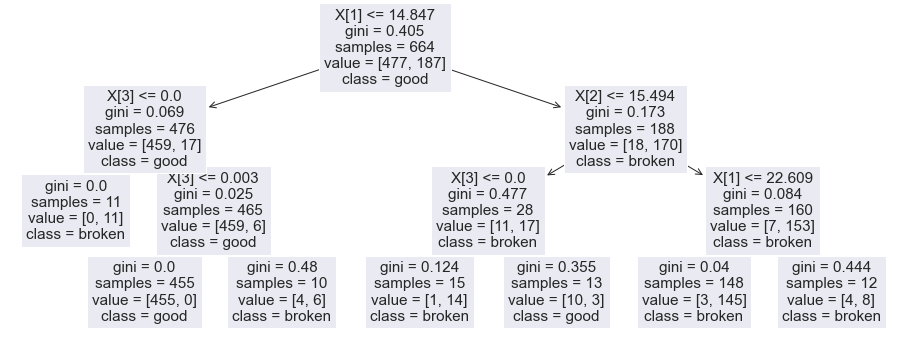

In [34]:
tree.plot_tree(clf[0], class_names = ['good', 'broken'])

Text(0.5, 1.0, 'distribution : number of days that are measured for each asset')

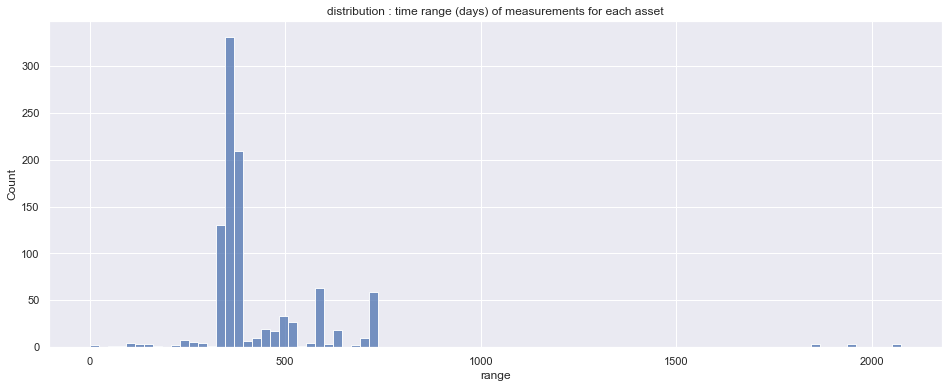

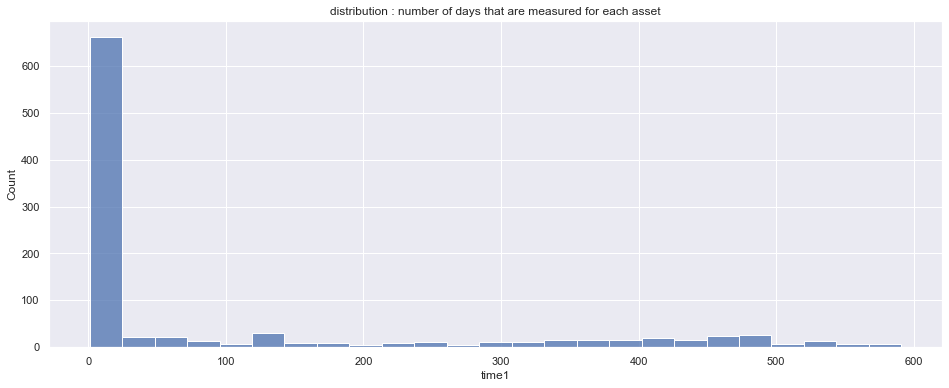

In [74]:
sns.histplot(statsDays['range'])
plt.title('distribution : time range (days) of measurements for each asset')
plt.figure()
sns.histplot(statsDays['time1'])
plt.title('distribution : number of days that are measured for each asset')


In [41]:
sum(statsDays['dist']>50)

310

In [58]:
dEv.groupby(['asset_id', 'time1']).max().groupby(['asset_id']).max()

,sensor,min,max,dist
asset_id,,,,
1,25.230769,24.0,30.0,4.510187
6,54.000000,54.0,54.0,0.000000
7,23.661458,21.5,26.5,0.000000
9,25.281250,22.5,28.0,0.000000
10,25.510417,23.0,39.5,4.640784
...,...,...,...,...
66367,17.545455,16.5,19.5,0.001674
66380,15.791667,14.0,17.0,0.001674
67432,18.500000,18.5,18.5,0.000000


<AxesSubplot:xlabel='dist', ylabel='Count'>

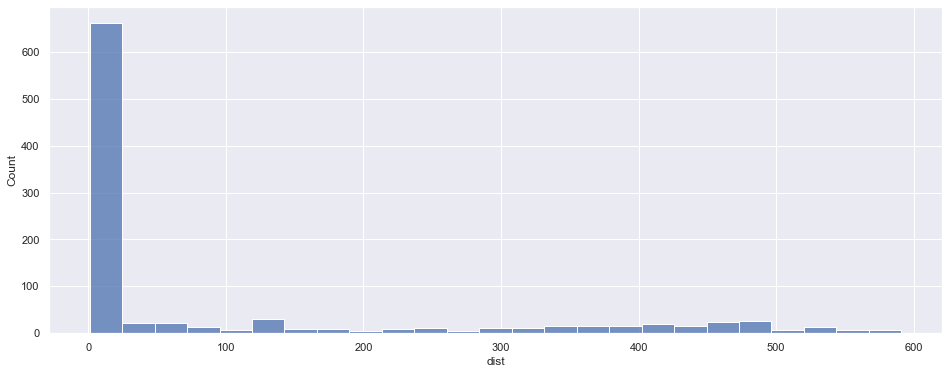

In [39]:
sns.histplot(statsDays['dist'])

Number of : Entire records / asset & timestamp(day) / asset-id 
8150913 103819 996


Text(0.5, 1.0, 'Distribution of measurement-per-day for one sensor')

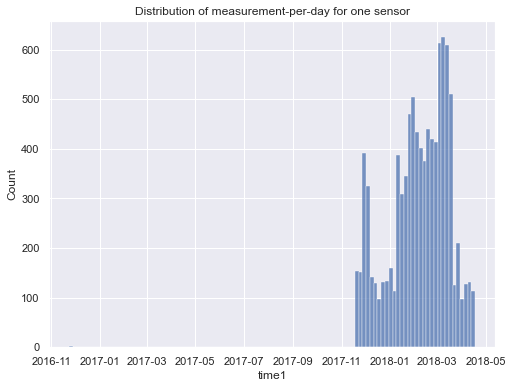

In [8]:
## some info about the final event-dataset
# - average: per-day 80 measurements
# - average: per-asset 100 days
print('Number of : Entire records / asset & timestamp(day) / asset-id ')
print( len(dEv), 
       len(dEv.groupby(['asset_id', 'time1']).count()),
       len(dEv.groupby(['asset_id']).count()) )


## Plot the times of one sensor
sp = dEv[dEv['asset_id'] == dEv.loc[2220, 'asset_id']]
sns.histplot(sp['time1'])
plt.title('Distribution of measurement-per-day for one sensor')
print('asset_id / meausred-days / duration-days : ', 
      sp.loc[0, 'asset_id'], len(sp['time1'].unique()),
      max(sp['time1']) - min(sp['time1']))

## Final form : asset-id -- time -- temperature -- lifetime

print('asset_id / meausred-days / duration-days : ', 
      sp['asset_id'].iloc[0], len(sp['time1'].unique()),
      (max(sp['time1']) - min(sp['time1'])).days)

In [9]:
## [ONLY RUN ONCE]
##    Preprocess and extract needed data from raw events.csv, which is too large and contain a lot redundant information.
##    This functions takes hours so that is only excuted once and results are saved into new files at '/data/out/'.

## The following steps are excuted:
##  - only keep columns 2,3,6,9  ('sensor', 'macaddress', 'time1', 'time2')
##  - for 'sensor': get 'temperature', discard 'battery/flag' 
##  - get 'day' from timestamp, we don't need to be too detailed
##  - inner-join with 'needed-assets', to shrink data size & add-Mac
def convertRawEvents(dNeed, num=0):
    N = 1000 * 1000
    d = []
    
    while True:
        df = pd.read_csv(DATA_PATH + '/events.csv', nrows = N, skiprows = num * N, header = None, 
                         usecols = [2,3,6,9], names = ['sensor', 'macaddress', 'time1', 'time2'])
        num += 1
        try:
            df['sensor'] = [float(i.split('\'')[-2]) if isinstance(i, str) else -100 for i in df['sensor'] ] ## sensor to temperature
            df['time1'] = [i.split(' ')[0] for i in df['time1']] ## time to date
            df['time2'] = [i.split(' ')[0] for i in df['time2']]
        except:
            print('some error happen in database!', num)
            continue
        
        df_filter = df.merge(dNeed, on = 'macaddress', how = 'inner') ## merge/filter mac
#         storeHdf(df_filter, hdfpath)
        
        if len(d):
            d = pd.concat([d, df_filter], ignore_index=True)
        else:
            d = df_filter
        
        if num % 10 == 0:
            d.to_csv(DATA_PATH + '/out/exEvents_%d.csv'%num, index=False)
            d = []
        
        if len(df) < N:
            break
        print('entry : ', num, end='\r')
    return d

# convertRawEvents(needAsset, num=70) ## in total 70m records


In [129]:
# fpath = DATA_PATH + '/out/extEvents.hdf5'
# fhd = h5py.File(fpath, 'a')
# for i in range(5): # append write each asset_id record to hdf 
#     entry = dict(dv.iloc[i])
#     dataId = str(entry['asset_id'])

#     if dataId not in fhd:
#         fhd[dataId] = str(entry) ## create a scalar-string entry
#     else:
#         d = fhd[dataId]
#         d[()] = d[()] + '\n' + str(entry)
